**Model Utility functions**

adapted from shadySource by Kyle Richmond-Crosset

In [1]:
import tensorflow as tf
from tensorflow.python.keras.layers import (InputLayer, Conv2D, Conv2DTranspose, 
            BatchNormalization, LeakyReLU, MaxPool2D, UpSampling2D, 
            Reshape, GlobalAveragePooling2D, Layer)
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from model_utils import ConvBnLRelu, SampleLayer
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import math

In [2]:
class ConvBnLRelu(object):
    def __init__(self, filters, kernelSize, strides=1):
        self.filters = filters
        self.kernelSize = kernelSize
        self.strides = strides
    # return conv + bn + leaky_relu model
    def __call__(self, net):
        net = Conv2D(self.filters, self.kernelSize, strides=self.strides, padding='same')(net)
        net = BatchNormalization()(net)
        net = LeakyReLU()(net)
        return net

In [3]:
class SampleLayer(Layer):
    '''
    Keras Layer to grab a random sample from a distribution (by multiplication)
    Computes "(normal)*stddev + mean" for the vae sampling operation
    (written for tf backend)

    Additionally,
        Applies regularization to the latent space representation.
        Can perform standard regularization or B-VAE regularization.

    call:
        pass in mean then stddev layers to sample from the distribution
        ex.
            sample = SampleLayer('bvae', 16)([mean, stddev])
    '''
    def __init__(self, latent_regularizer='bvae', beta=69., capacity=0., randomSample=True, **kwargs):
        '''
        args:
        ------
        latent_regularizer : str
            Either 'bvae', 'vae', or 'no'
            Determines whether regularization is applied
                to the latent space representation.
        beta : float
            beta > 1, used for 'bvae' latent_regularizer,
            (Unused if 'bvae' not selected)
        capacity : float
            used for 'bvae' to try to break input down to a set number
                of basis. (e.g. at 25, the network will try to use 
                25 dimensions of the latent space)
            (unused if 'bvae' not selected)
        randomSample : bool
            whether or not to use random sampling when selecting from distribution.
            if false, the latent vector equals the mean, essentially turning this into a
                standard autoencoder.
        ------
        ex.
            sample = SampleLayer('bvae', 16)([mean, stddev])
        '''
        self.reg = latent_regularizer
        self.beta = beta
        self.capacity = capacity
        self.random = randomSample
        super(SampleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # save the shape for distribution sampling
        self.shape = input_shape[0]
        print(self.shape)
        super(SampleLayer, self).build(input_shape) # needed for layers

    def call(self, x):
        if len(x) != 2:
            raise Exception('input layers must be a list: mean and stddev')
        if len(x[0].shape) != 2 or len(x[1].shape) != 2:
            raise Exception('input shape is not a vector [batchSize, latentSize]')

        mean = x[0]
        stddev = x[1]

        if self.reg == 'bvae':
            # kl divergence:
            latent_loss = -0.5 * K.mean(1 + stddev
                                - K.square(mean)
                                - K.exp(stddev), axis=-1)
            # use beta to force less usage of vector space:
            # also try to use <capacity> dimensions of the space:
            latent_loss = self.beta * K.abs(latent_loss - self.capacity/self.shape.as_list()[1])
            self.add_loss(latent_loss, x)
        elif self.reg == 'vae':
            # kl divergence:
            latent_loss = -0.5 * K.mean(1 + stddev
                                - K.square(mean)
                                - K.exp(stddev), axis=-1)
            self.add_loss(latent_loss, x)

        epsilon = K.random_normal(shape=self.shape,
                              mean=0., stddev=1.)
        if self.random:
            # 'reparameterization trick':
            return mean + K.exp(stddev) * epsilon
        else: # do not perform random sampling, simply grab the impulse value
            return mean + 0*stddev # Keras needs the *0 so the gradinent is not None

    def compute_output_shape(self, input_shape):
        return input_shape[0]

Models

In [4]:
class Architecture(object):
    '''
    generic architecture template
    '''
    def __init__(self, inputShape=None, batchSize=None, latentSize=None):
        '''
        params:
        ---------
        inputShape : tuple
            the shape of the input, expecting 3-dim images (h, w, 3)
        batchSize : int
            the number of samples in a batch
        latentSize : int
            the number of dimensions in the two output distribution vectors -
            mean and std-deviation
        '''
        self.inputShape = inputShape
        self.batchSize = batchSize
        self.latentSize = latentSize

        self.model = self.Build()

    def Build(self):
        raise NotImplementedError('architecture must implement Build function')

In [5]:
class Darknet19Encoder(Architecture):
    '''
    This encoder predicts distributions then randomly samples them.
    Regularization may be applied to the latent space output

    a simple, fully convolutional architecture inspried by
        pjreddie's darknet architecture
    https://github.com/pjreddie/darknet/blob/master/cfg/darknet19.cfg
    '''
    def __init__(self, inputShape=(40, 56, 3), batchSize=1,
                 latentSize=32, latentConstraints='bvae', beta=69., capacity=0.,
                 randomSample=True):
        '''
        params
        -------
        latentConstraints : str
            Either 'bvae', 'vae', or 'no'
            Determines whether regularization is applied
                to the latent space representation.
        beta : float
            beta > 1, used for 'bvae' latent_regularizer
            (Unused if 'bvae' not selected, default 100)
        capacity : float
            used for 'bvae' to try to break input down to a set number
                of basis. (e.g. at 25, the network will try to use
                25 dimensions of the latent space)
            (unused if 'bvae' not selected)
        randomSample : bool
            whether or not to use random sampling when selecting from distribution.
            if false, the latent vector equals the mean, essentially turning this into a
                standard autoencoder.
        '''
        self.latentConstraints = latentConstraints
        self.beta = beta
        self.latentCapacity = capacity
        self.randomSample = randomSample
        super().__init__(inputShape, batchSize, latentSize)

    def Build(self):
        # create the input layer for feeding the netowrk
        inLayer = Input(self.inputShape, self.batchSize)
        net = ConvBnLRelu(32, kernelSize=3)(inLayer) # 1
        net = MaxPool2D((2, 2), strides=(2, 2))(net)

        net = ConvBnLRelu(64, kernelSize=3)(net) # 2
        net = MaxPool2D((2, 2), strides=(2, 2))(net)

        net = ConvBnLRelu(128, kernelSize=3)(net) # 3
        net = ConvBnLRelu(64, kernelSize=1)(net) # 4
        net = ConvBnLRelu(128, kernelSize=3)(net) # 5
        net = MaxPool2D((2, 2), strides=(2, 2))(net)

        net = ConvBnLRelu(256, kernelSize=3)(net) # 6
        net = ConvBnLRelu(128, kernelSize=1)(net) # 7
        net = ConvBnLRelu(256, kernelSize=3)(net) # 8
        net = MaxPool2D((2, 2), strides=(2, 2))(net)

        #net = ConvBnLRelu(512, kernelSize=3)(net) # 9
        #net = ConvBnLRelu(256, kernelSize=1)(net) # 10
        #net = ConvBnLRelu(512, kernelSize=3)(net) # 11
        #net = ConvBnLRelu(256, kernelSize=1)(net) # 12
        #net = ConvBnLRelu(512, kernelSize=3)(net) # 13
        print(net.shape)
        #net = MaxPool2D((2, 2), strides=(2, 2))(net)

        #net = ConvBnLRelu(1024, kernelSize=3)(net) # 14
        #net = ConvBnLRelu(512, kernelSize=1)(net) # 15
        #net = ConvBnLRelu(1024, kernelSize=3)(net) # 16
        #net = ConvBnLRelu(512, kernelSize=1)(net) # 17
        #net = ConvBnLRelu(1024, kernelSize=3)(net) # 18

        # variational encoder output (distributions)
        mean = Conv2D(filters=self.latentSize, kernel_size=(1, 1),
                      padding='same')(net)
        mean = GlobalAveragePooling2D()(mean)
        stddev = Conv2D(filters=self.latentSize, kernel_size=(1, 1),
                        padding='same')(net)
        stddev = GlobalAveragePooling2D()(stddev)
        print(stddev.shape)
        sample = SampleLayer(self.latentConstraints, self.beta,
                            self.latentCapacity, self.randomSample)([mean, stddev])
        print(sample.shape)
        return Model(inputs=inLayer, outputs=sample)

In [6]:
class Darknet19Decoder(Architecture):
    def __init__(self, inputShape=(40, 56, 3), batchSize=1, latentSize=32):
        super().__init__(inputShape, batchSize, latentSize)

    def Build(self):
        # input layer is from GlobalAveragePooling:
        inLayer = Input([self.latentSize], self.batchSize)
        # reexpand the input from flat:
        net = Reshape((1, 1, self.latentSize))(inLayer)
        print(net.shape)
        # darknet downscales input by a factor of 32, so we upsample to the second to last output shape:
        net = UpSampling2D((5,7))(net)
        print(net.shape)
        # TODO try inverting num filter arangement (e.g. 512, 1204, 512, 1024, 512)
        # and also try (1, 3, 1, 3, 1) for the filter shape
        #net = ConvBnLRelu(1024, kernelSize=3)(net)
        #net = ConvBnLRelu(512, kernelSize=1)(net)
        #net = ConvBnLRelu(1024, kernelSize=3)(net)
        #net = ConvBnLRelu(512, kernelSize=1)(net)
        #net = ConvBnLRelu(1024, kernelSize=3)(net)

        #net = UpSampling2D((2, 2))(net)
        #net = ConvBnLRelu(512, kernelSize=3)(net)
        #net = ConvBnLRelu(256, kernelSize=1)(net)
        #net = ConvBnLRelu(512, kernelSize=3)(net)
        #net = ConvBnLRelu(256, kernelSize=1)(net)
        #net = ConvBnLRelu(512, kernelSize=3)(net)

        #net = UpSampling2D((2, 2))(net)
        net = ConvBnLRelu(256, kernelSize=3)(net)
        net = ConvBnLRelu(128, kernelSize=1)(net)
        net = ConvBnLRelu(256, kernelSize=3)(net)

        net = UpSampling2D((2, 2))(net)
        net = ConvBnLRelu(128, kernelSize=3)(net)
        net = ConvBnLRelu(64, kernelSize=1)(net)
        net = ConvBnLRelu(128, kernelSize=3)(net)

        net = UpSampling2D((2, 2))(net)
        net = ConvBnLRelu(64, kernelSize=3)(net)

        net = UpSampling2D((2, 2))(net)
        net = ConvBnLRelu(64, kernelSize=1)(net)
        net = ConvBnLRelu(32, kernelSize=3)(net)
        net = ConvBnLRelu(3, kernelSize=1)(net)
        net = Conv2D(filters=self.inputShape[-1], kernel_size=(1, 1),
                      padding='same', activation="sigmoid")(net)

        return Model(inLayer, net)


In [7]:
class Darknet53Encoder(Architecture):
    '''
    a larger, fully convolutional architecture inspried by
        pjreddie's darknet architecture
    https://github.com/pjreddie/darknet/blob/master/cfg/darknet19.cfg
    https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    https://pjreddie.com/media/files/papers/YOLOv3.pdf
    '''
    def __init__(self, inputShape=(None, None, None, None), name='darkent53_encoder'):
        '''
        input shape for the network, a name for the scope, and a data format.
        '''
        super().__init__(inputShape, name)
        self.Build()

    def Build(self):
        '''
        builds darknet53 encoder network
        '''
        raise NotImplementedError('this architecture is not complete')

    def ConvBlock(self):
        '''
        adds a darknet conv block to the net
        '''
        raise NotImplementedError('this architecture is not complete')

In [8]:
def test_enc_dec():
    d19e = Darknet19Encoder()
    d19e.model.summary()
    d19d = Darknet19Decoder()
    d19d.model.summary()

In [9]:
test_enc_dec()

(1, 2, 3, 256)
(1, 32)
(1, 32)
(1, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 40, 56, 3)       0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 40, 56, 32)      896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 40, 56, 32)      128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (1, 40, 56, 32)      0           batch_normalization[0][0]        
______________________________________________________________________

Main functions and classes

In [10]:
class AutoEncoder(object):
    def __init__(self, encoderArchitecture,
                 decoderArchitecture):

        self.encoder = encoderArchitecture.model
        self.decoder = decoderArchitecture.model

        self.ae = Model(self.encoder.inputs, self.decoder(self.encoder.outputs))

In [11]:

inputShape = (40,56,3)
batchSize = 100
latentSize = 32

img = np.load("/home/krichmo1/summer2018/vae/images_for_vision.npy")
data = []
for i in range(len(img)):
    data.append(img[i][:, 2:58, :])
data = np.array(data)
np.random.shuffle(data)
img = data

#img = np.array(img, dtype=np.float32) / 255 - 0.5
#img = np.array([img]*batchSize) # make fake batches to improve GPU utilization

# This is how you build the autoencoder
encoder = Darknet19Encoder(inputShape, batchSize, latentSize, 'no', beta=1, capacity=15, randomSample=True)
decoder = Darknet19Decoder(inputShape, batchSize, latentSize)
bvae = AutoEncoder(encoder, decoder)

bvae.ae.compile(optimizer='rmsprop', loss='mean_absolute_error')

(100, 2, 3, 256)
(100, 32)
(100, 32)
(100, 32)
(100, 1, 1, 32)
(100, 5, 7, 32)


In [12]:
bvae.ae.fit(img, img,
                epochs=10,
                batch_size=batchSize)


Epoch 1/10
10000/10000 [==============================] - 369s 37ms/step - loss: nan
Epoch 2/10
10000/10000 [==============================] - 260s 26ms/step - loss: nan
Epoch 3/10
10000/10000 [==============================] - 262s 26ms/step - loss: nan
Epoch 4/10
10000/10000 [==============================] - 263s 26ms/step - loss: nan
Epoch 5/10
10000/10000 [==============================] - 269s 27ms/step - loss: nan
Epoch 6/10
10000/10000 [==============================] - 268s 27ms/step - loss: nan
Epoch 7/10
10000/10000 [==============================] - 263s 26ms/step - loss: nan
Epoch 8/10
10000/10000 [==============================] - 271s 27ms/step - loss: nan
Epoch 9/10
10000/10000 [==============================] - 272s 27ms/step - loss: nan
Epoch 10/10
10000/10000 [==============================] - 271s 27ms/step - loss: nan


In [13]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width, channel = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2], samples.shape[3]
    print(np.array(samples.shape))
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width, channel])
    samples = np.transpose(samples, axes=[1, 0, 2, 3, 4])
    samples = np.reshape(samples, [height*cnt, width*cnt, channel])
    return samples

(10000, 40, 56, 3)
[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 ...

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
[100  40  56   3]


/home/krichmo1/envs/summer18/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


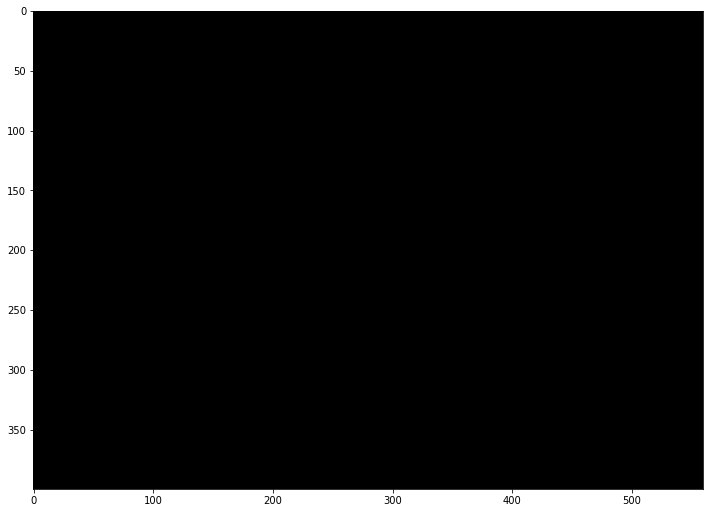

[100  40  56   3]


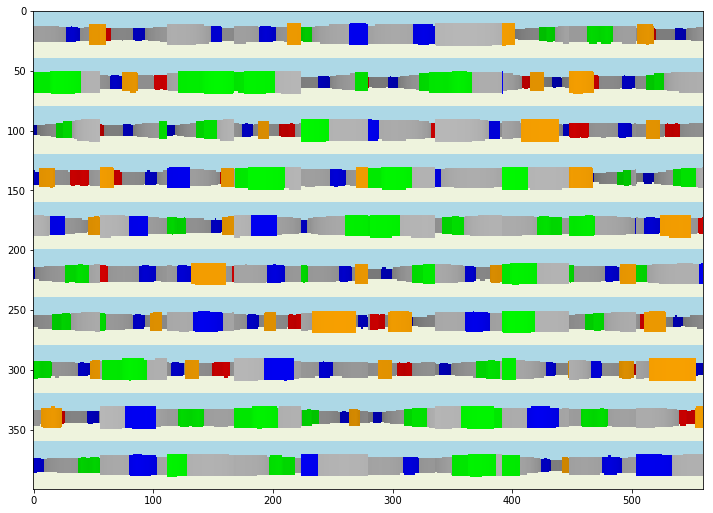

In [14]:
print(img.shape)

#latentVec = bvae.encoder.predict(img, batch_size=100)
#print(latentVec)

pred = bvae.ae.predict(img[0:100], batch_size=100) # get the reconstructed image
#pred[pred > 0.5] = 0.5 # clean it up a bit
#pred[pred < -0.5] = -0.5
#pred = np.uint8((pred + 0.5)* 255)
print(pred[0])
plt.figure(figsize=(12,16))
plt.imshow(convert_to_display(pred[0:100]), cmap='Greys_r')

plt.show()

plt.figure(figsize=(12,16))
plt.imshow(convert_to_display(img[0:100]), cmap='Greys_r')

plt.show()


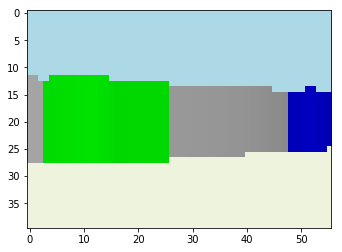

In [16]:
imageToUse = img[0]
plt.imshow(np.reshape(imageToUse,[40,56,3]), interpolation="nearest", cmap="gray")

In [15]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

def showModifications(images):

    activations = []
    
    activations = bvae.encoder.predict(images, batch_size=100)
    print(activations.shape)
    z_dim = len(activations[0])
    
    index = 0
    
    #start_image = sess.run(gen_x, feed_dict={gen_z: activations})
    plt.figure(1, figsize=(80,80))
    plt.imshow(np.reshape(images[0],[40,56,3]), interpolation="nearest", cmap="gray")
    print("flage")
    plt.show()
    
    plt.figure(2, figsize=(80,80))
    pred = bvae.ae.predict(images, batch_size=100)[0]
    plt.imshow(np.reshape(pred,[40,56,3]), interpolation="nearest", cmap="gray")
    plt.show()
    
    cont_var = 10

    for j in range(z_dim):
        print(j)
        actmins = -3
        actmaxs = 3
        original_act = activations[0][j]
        act = actmins
        step = (actmaxs + abs(act))/cont_var
        for k in range(cont_var): 
            activations[0][j] = act
            plt.subplot(z_dim+2, cont_var, index + cont_var + 1)
            index += 1
            auto_image = bvae.decoder.predict_on_batch(activations[0:100])[0]
            plt.imshow(np.reshape(auto_image,[40,56,3]), interpolation="nearest", cmap="gray")
            plot.show()
            act += step
        activations[0][j] = original_act

(100, 32)
flage


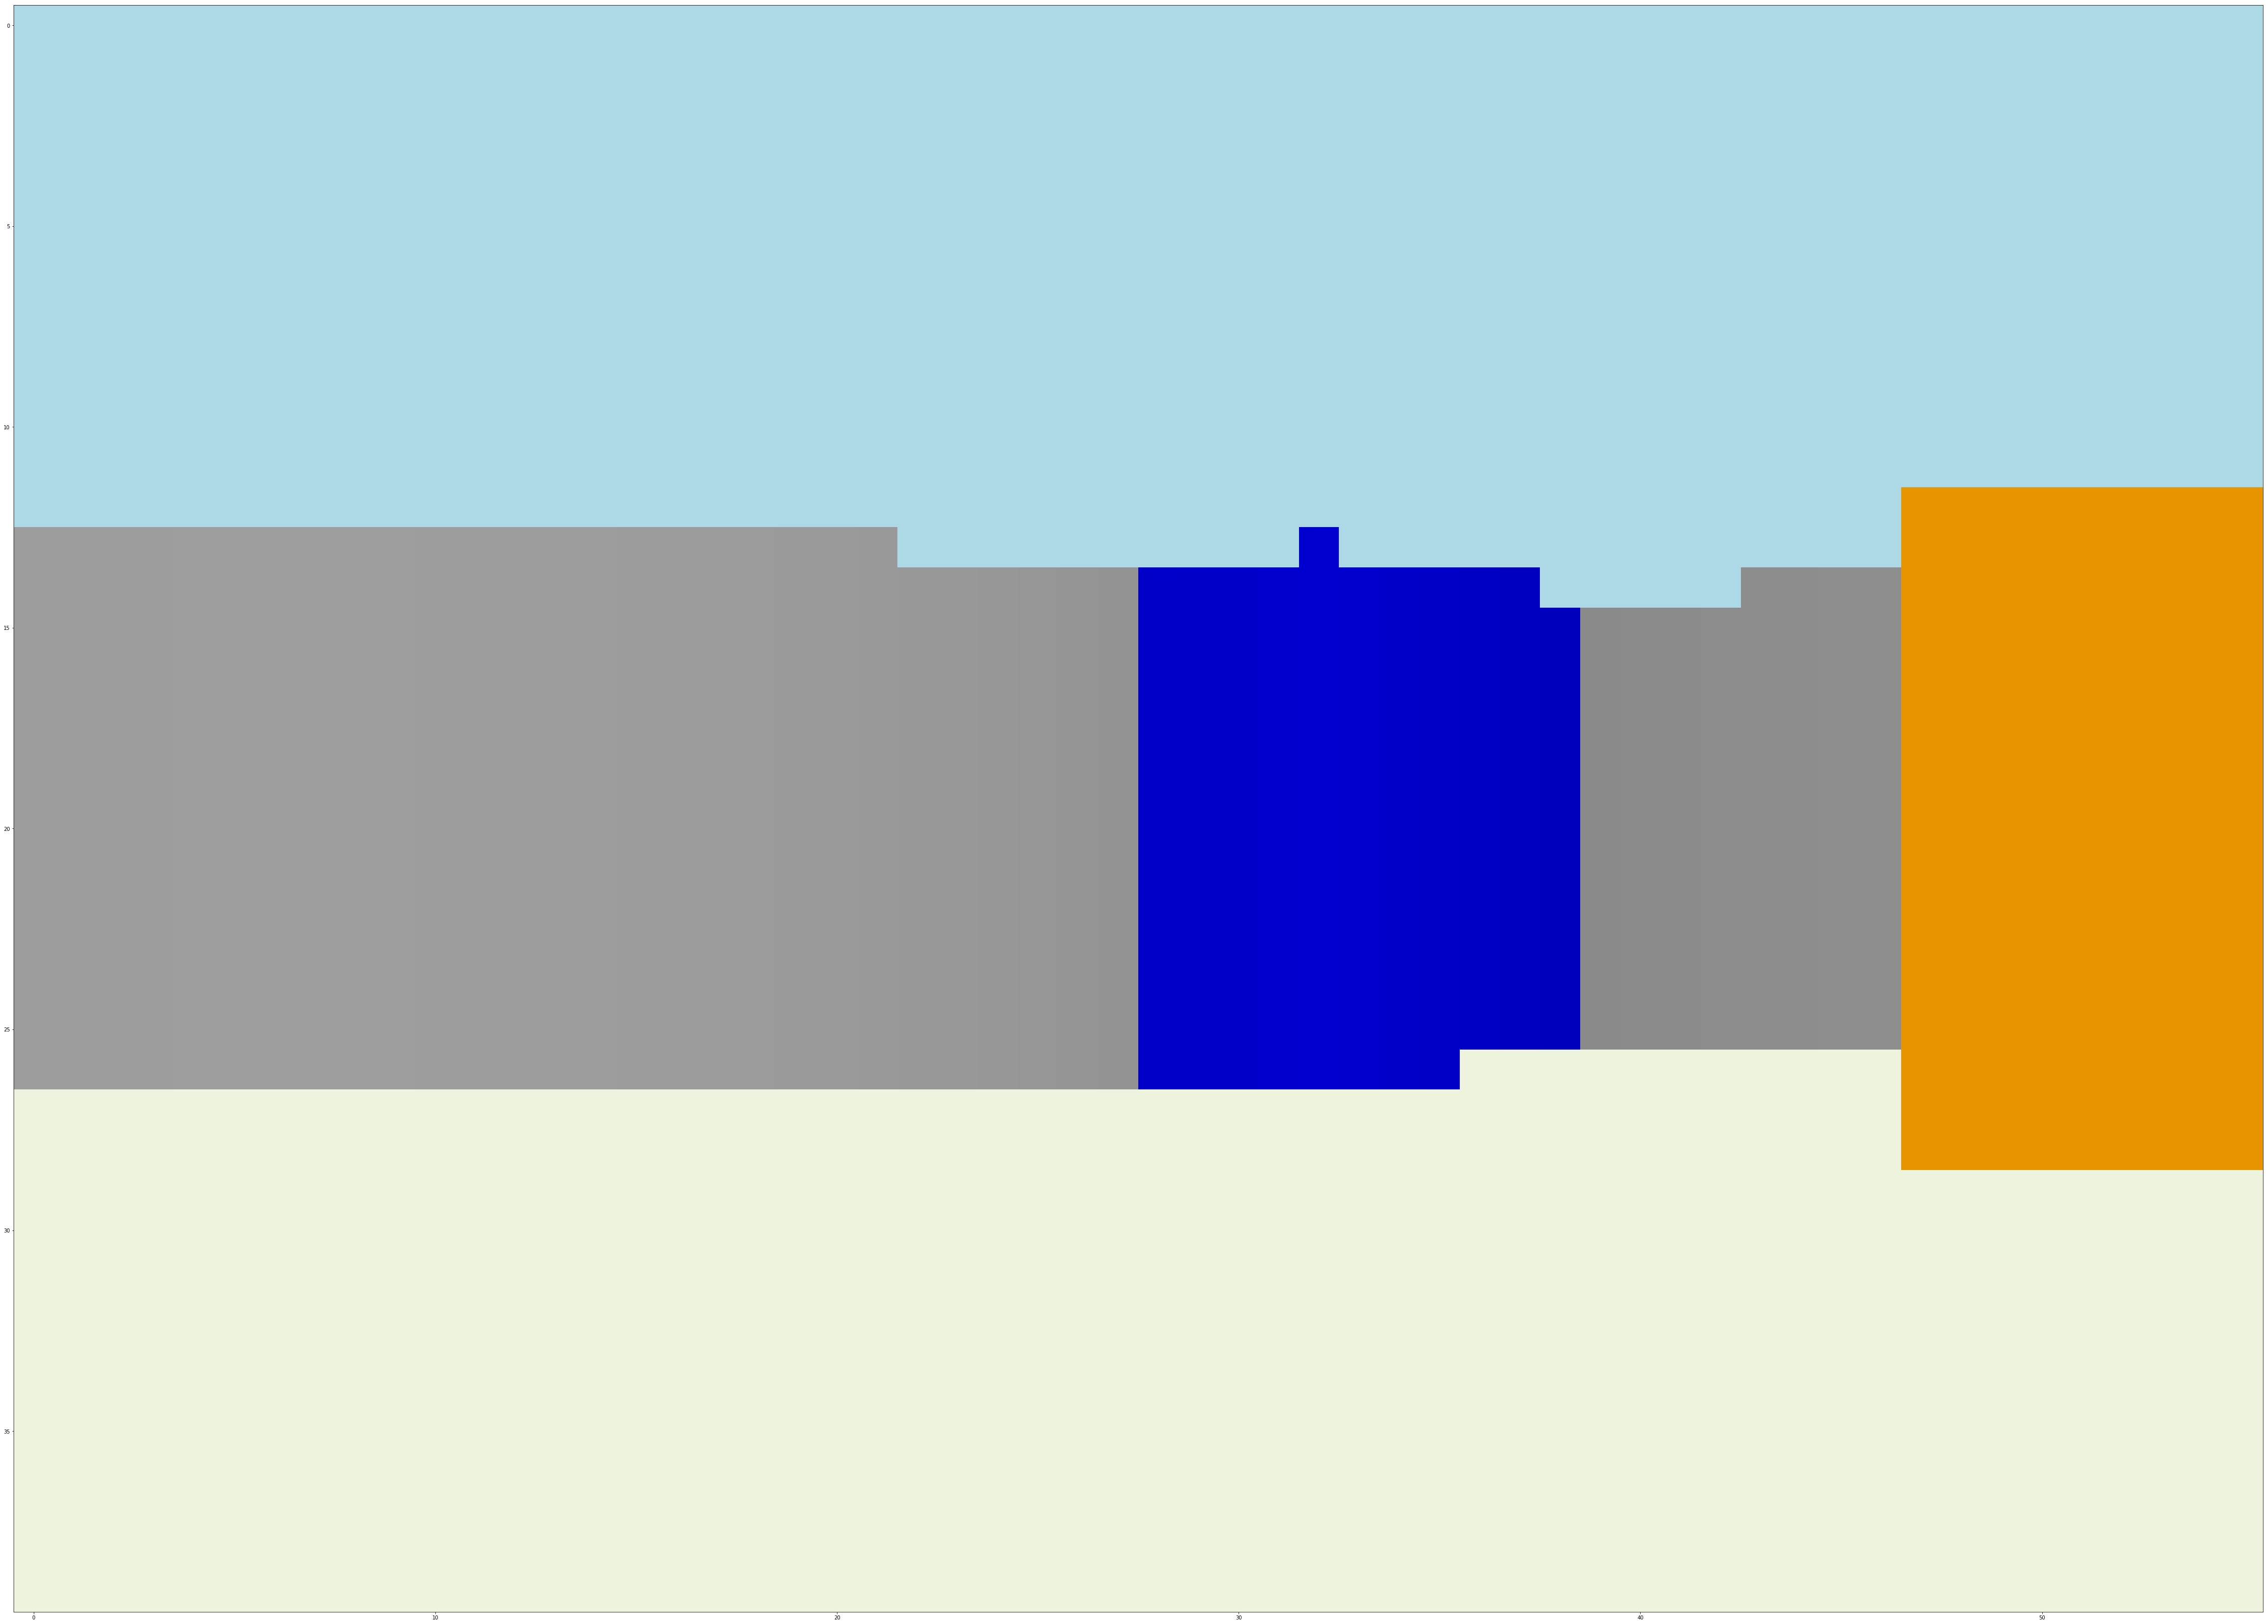

/home/krichmo1/envs/summer18/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


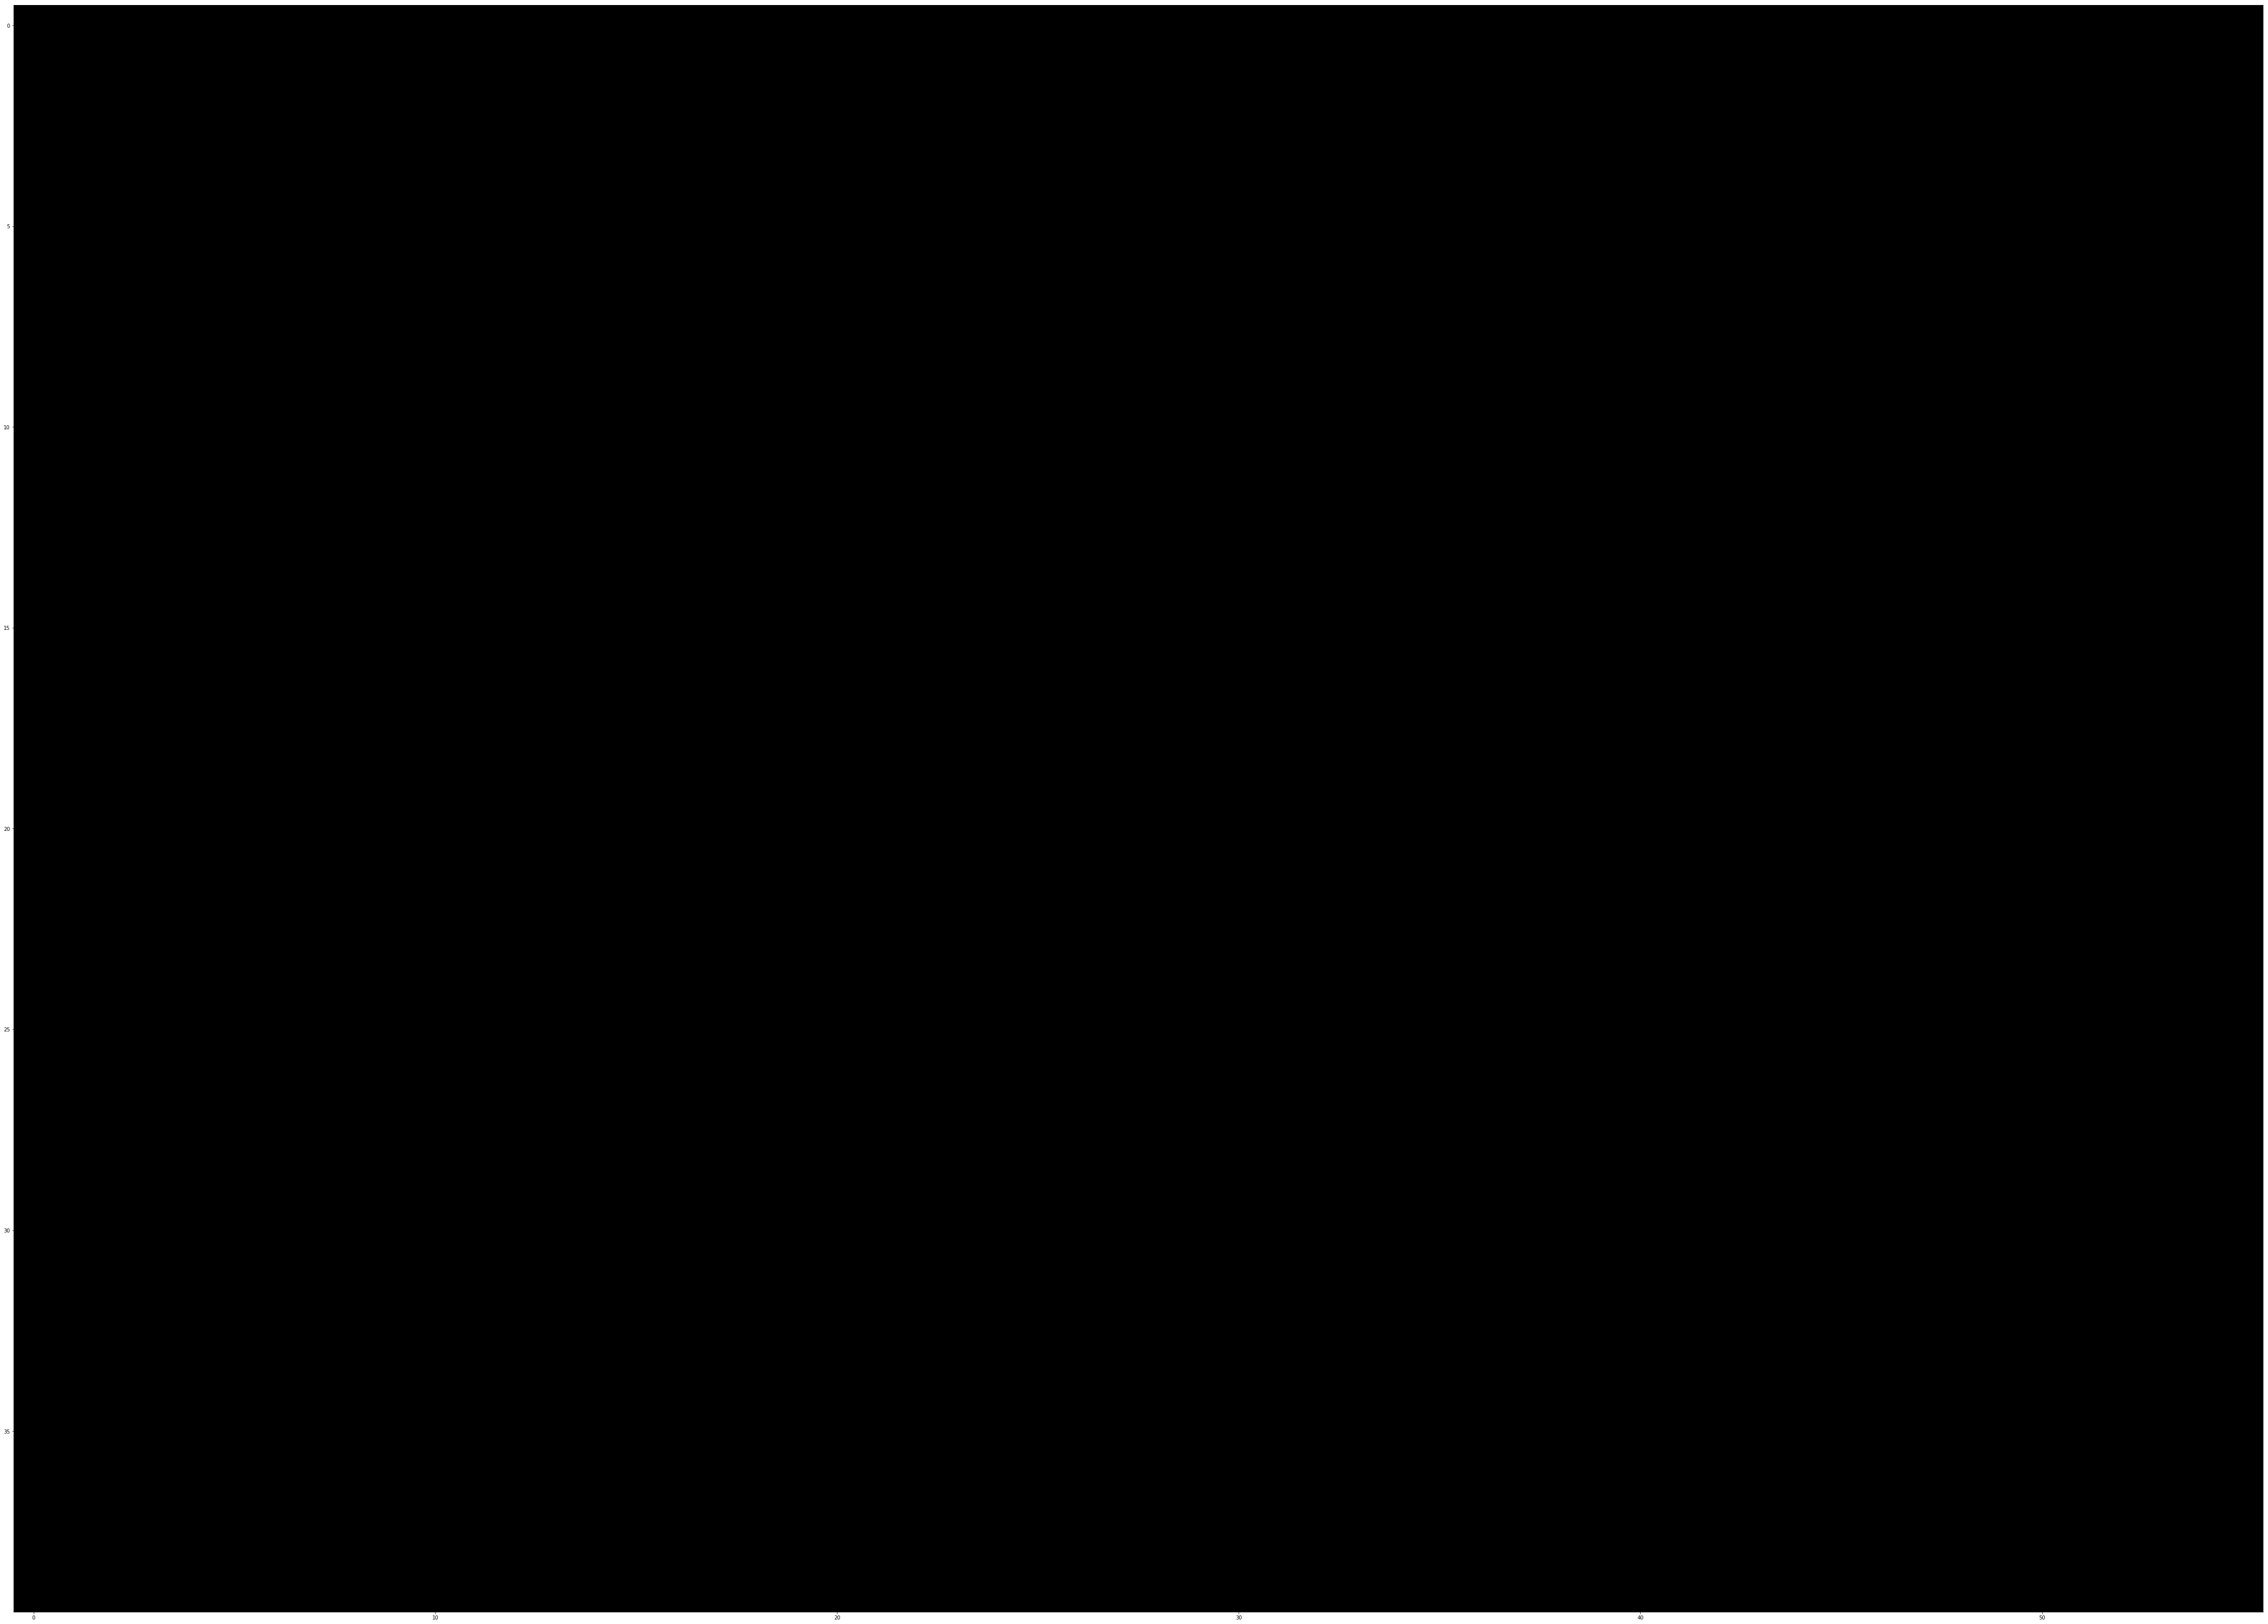

0


NameError: name 'plot' is not defined

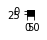

In [16]:
showModifications(img[0:100])